In [14]:
'''
Patrick Ballou
ID: 801130521
ECGR 4106
Homework 1
Problem 1
'''

'\nPatrick Ballou\nID: 801130521\nECGR 4106\nHomework 1\nProblem 1\n'

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import cuda
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [16]:
#check if GPU is available and set the device accordingly
#device = 'torch.device("cuda:0" if torch.cuda.is_available() else "cpu")'
device = 'cuda'
print("Using GPU: ", cuda.get_device_name())

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Using GPU:  Quadro T2000
Wed Feb  7 02:18:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.23                 Driver Version: 551.23         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro T2000                 WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   41C    P8              6W /   60W |    1621MiB /   4096MiB |      8%      Default |
|                                         |                        |                  N/A |
+----------------------

# **Problem 1A:**

In [17]:
data_path = '../../Datasets'
normalizing_set = datasets.CIFAR10(root=data_path, train=True, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [18]:
images = torch.stack([img_t for img_t, _ in normalizing_set], dim=3)
mean = images.view(3, -1).mean(dim=1)
std = images.view(3, -1).std(dim=1)

normalizer = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean,std)])

cifar_train = datasets.CIFAR10(root=data_path, train=True, transform=normalizer)
cifar_val = datasets.CIFAR10(root=data_path, train=False, transform=normalizer)

train_loader = DataLoader(cifar_train, batch_size=64, shuffle=True)
val_loader = DataLoader(cifar_val, batch_size=64, shuffle=False)

In [19]:
class CifarNet(nn.Module):
    def __init__(self):
        super(CifarNet, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = CifarNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

epochs = 20

training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []

In [20]:
for epoch in range(epochs):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit=' batch') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.update()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        training_losses.append(running_loss / len(train_loader))
        training_accuracies.append(100 * correct / total)
        
        model.eval()
        
        running_loss = 0.0
        correct = 0
        total = 0
        predicted_labels = []
        true_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                predicted_labels.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        
        validation_losses.append(running_loss / len(val_loader))
        validation_accuracies.append(100 * correct / total)
        
        pbar.set_postfix({'Training Loss ': training_losses[-1], 'Validation Loss ': validation_losses[-1]})

torch.save(model.state_dict(), '../../Models/hw1_1a.pth')

Epoch 1/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 2/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 3/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 4/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 5/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 6/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 7/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 8/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 9/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 10/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 11/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 12/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 13/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 14/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 15/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 16/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 17/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 18/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 19/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 20/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Final Training Loss: 1.6622318390690152
Final Validation Loss: 1.6518301948620255
Final Training Accuracy: 41.076
Final Validation Accuracy: 41.71
              precision    recall  f1-score   support

           0       0.53      0.45      0.48      1000
           1       0.46      0.54      0.49      1000
           2       0.34      0.22      0.27      1000
           3       0.30      0.23      0.26      1000
           4       0.37      0.32      0.34      1000
           5       0.39      0.34      0.36      1000
           6       0.38      0.54      0.45      1000
           7       0.42      0.46      0.44      1000
           8       0.47      0.58      0.52      1000
           9       0.47      0.49      0.48      1000

    accuracy                           0.42     10000
   macro avg       0.41      0.42      0.41     10000
weighted avg       0.41      0.42      0.41     10000



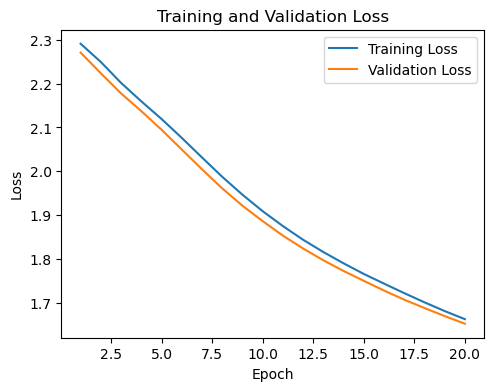

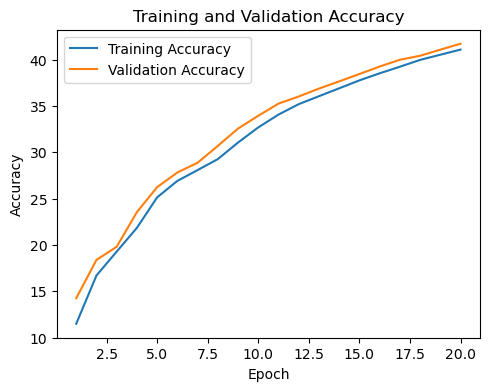

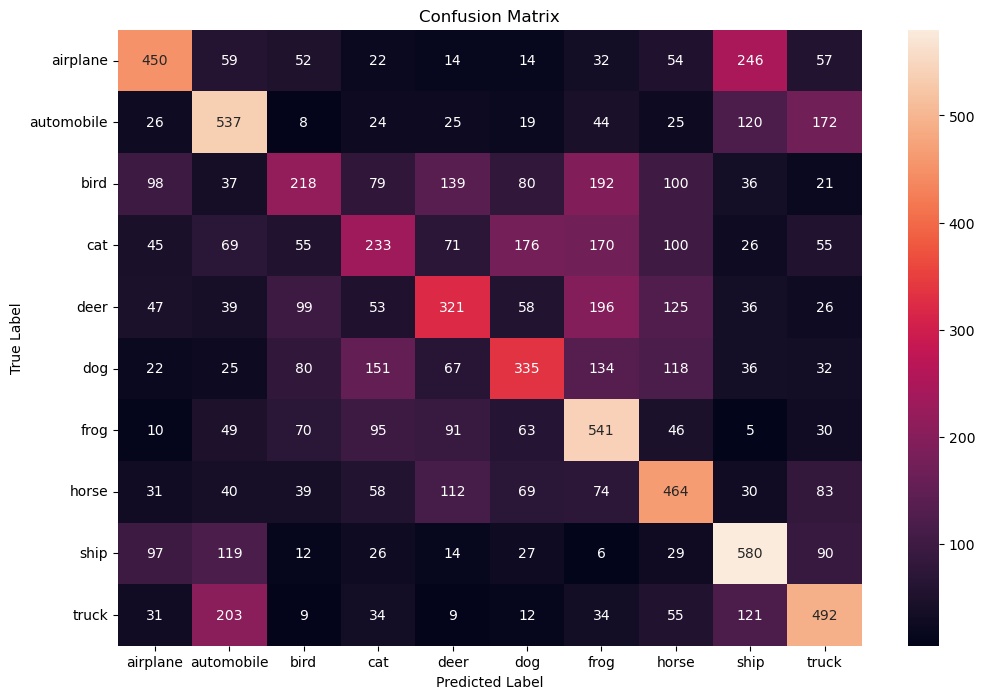

In [21]:
print("Final Training Loss:", training_losses[-1])
print("Final Validation Loss:", validation_losses[-1])
print("Final Training Accuracy:", training_accuracies[-1])
print("Final Validation Accuracy:", validation_accuracies[-1])
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_losses, label='Training Loss')
plt.plot(epochs_range, validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_accuracies, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)
print(metrics.classification_report(true_labels, predicted_labels))

class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **Problem 1B:**

In [22]:
data_path = '../../Datasets'
normalizing_set = datasets.CIFAR10(root=data_path, train=True, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [23]:
images = torch.stack([img_t for img_t, _ in normalizing_set], dim=3)
mean = images.view(3, -1).mean(dim=1)
std = images.view(3, -1).std(dim=1)

normalizer = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean,std)])

cifar_train = datasets.CIFAR10(root=data_path, train=True, transform=normalizer)
cifar_val = datasets.CIFAR10(root=data_path, train=False, transform=normalizer)

train_loader = DataLoader(cifar_train, batch_size=64, shuffle=True)
val_loader = DataLoader(cifar_val, batch_size=64, shuffle=False)

In [24]:
class CifarNet(nn.Module):
    def __init__(self):
        super(CifarNet, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(32*32*3, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 16)
        self.fc6 = nn.Linear(16, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

model = CifarNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

epochs = 20

training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []

In [25]:
for epoch in range(epochs):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit=' batch') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.update()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        training_losses.append(running_loss / len(train_loader))
        training_accuracies.append(100 * correct / total)
        
        model.eval()
        
        running_loss = 0.0
        correct = 0
        total = 0
        predicted_labels = []
        true_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                predicted_labels.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        
        validation_losses.append(running_loss / len(val_loader))
        validation_accuracies.append(100 * correct / total)
        
        pbar.set_postfix({'Training Loss ': training_losses[-1], 'Validation Loss ': validation_losses[-1]})

torch.save(model.state_dict(), '../../Models/hw1_1b.pth')

Epoch 1/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 2/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 3/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 4/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 5/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 6/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 7/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 8/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 9/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 10/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 11/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 12/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 13/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 14/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 15/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 16/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 17/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 18/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 19/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Epoch 20/20:   0%|          | 0/782 [00:00<?, ? batch/s]

Final Training Loss: 2.103359831720972
Final Validation Loss: 2.0812858092557094
Final Training Accuracy: 21.832
Final Validation Accuracy: 22.46
              precision    recall  f1-score   support

           0       0.35      0.47      0.40      1000
           1       0.28      0.01      0.02      1000
           2       0.26      0.04      0.08      1000
           3       0.15      0.50      0.23      1000
           4       0.00      0.00      0.00      1000
           5       0.12      0.16      0.14      1000
           6       0.24      0.01      0.02      1000
           7       0.67      0.00      0.00      1000
           8       0.31      0.47      0.37      1000
           9       0.26      0.58      0.36      1000

    accuracy                           0.22     10000
   macro avg       0.26      0.22      0.16     10000
weighted avg       0.26      0.22      0.16     10000



c:\Users\patri\anaconda3\envs\dl_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\patri\anaconda3\envs\dl_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\patri\anaconda3\envs\dl_env\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


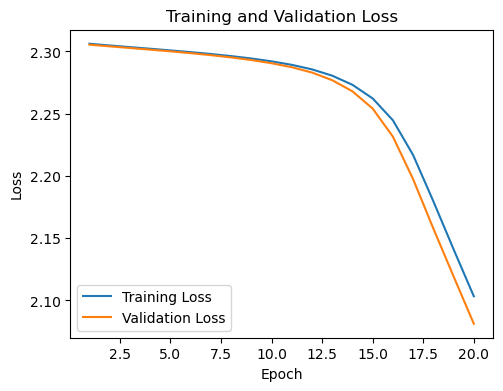

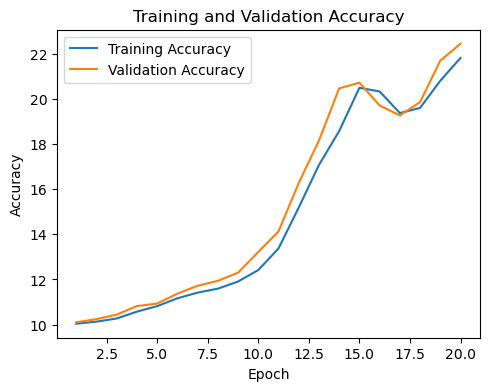

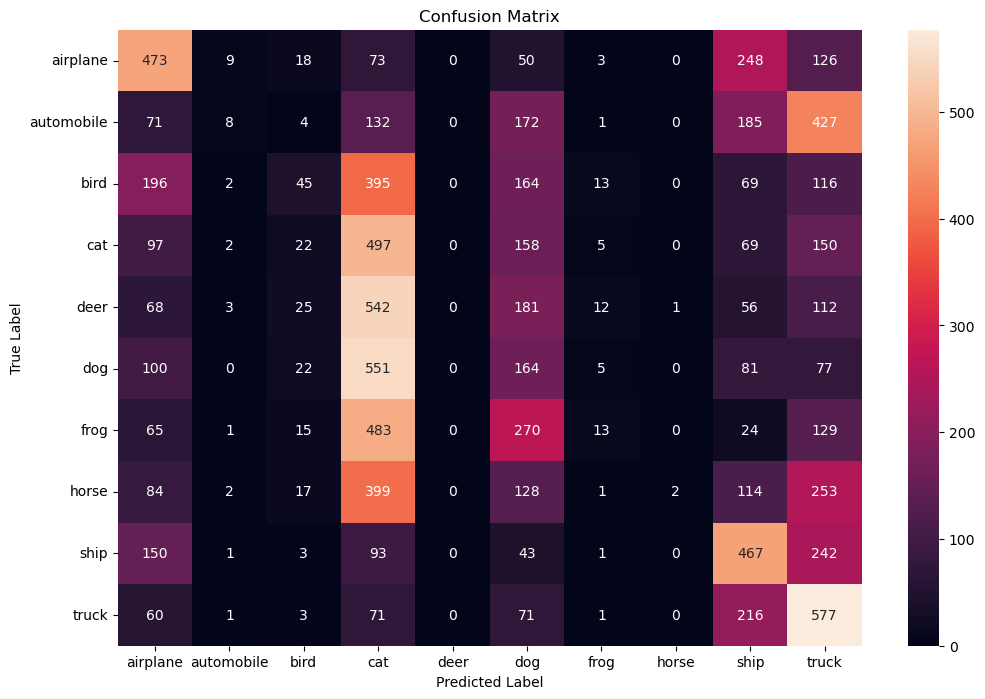

In [26]:
print("Final Training Loss:", training_losses[-1])
print("Final Validation Loss:", validation_losses[-1])
print("Final Training Accuracy:", training_accuracies[-1])
print("Final Validation Accuracy:", validation_accuracies[-1])
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_losses, label='Training Loss')
plt.plot(epochs_range, validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_accuracies, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)
print(metrics.classification_report(true_labels, predicted_labels))

class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()